In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Datasets/spx.csv')
df['date'] = pd.to_datetime(df['date'])
print(df.head())
print(df.tail())

        date   close
0 1986-01-02  209.59
1 1986-01-03  210.88
2 1986-01-06  210.65
3 1986-01-07  213.80
4 1986-01-08  207.97
           date    close
8187 2018-06-25  2717.07
8188 2018-06-26  2723.06
8189 2018-06-27  2699.63
8190 2018-06-28  2716.31
8191 2018-06-29  2718.37


C:\Users\bbate\Miniconda3\envs\keras-gpu\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


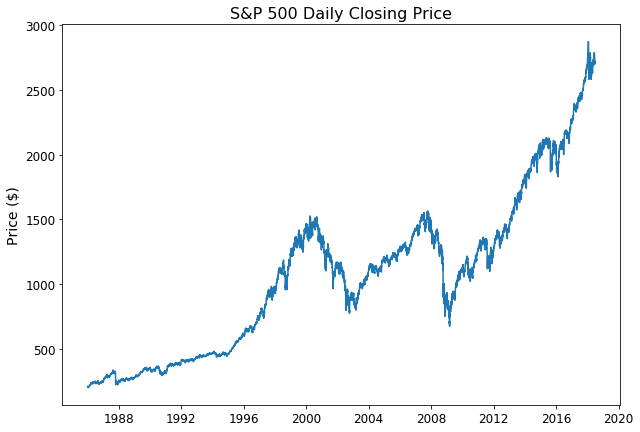

In [3]:
#
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(df.date, df.close)
ax.set_title('S&P 500 Daily Closing Price', 
             fontsize = 16)
ax.set_ylabel('Price ($)', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

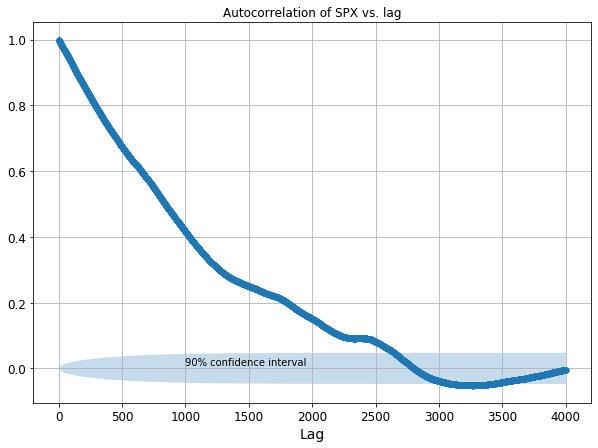

In [4]:
max_lag = 4000
fig, ax = plt.subplots(figsize = (10, 7))
acf_plot = plot_acf(x = df.close,
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of SPX vs. lag')
ax.grid(True)
ax.text(1000, 0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

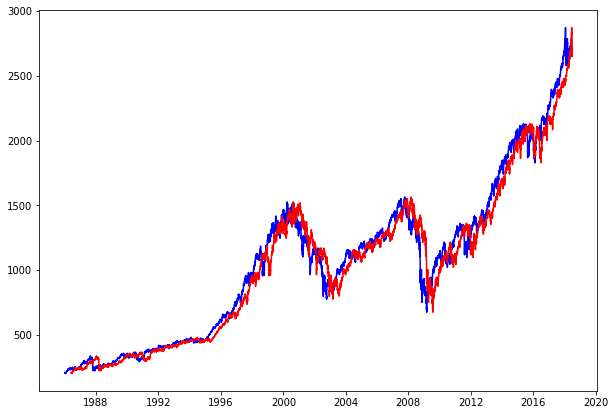

In [5]:
spx_shift_100 = df.copy()
spx_shift_100['close'] = df.close.shift(100)
#
fix, ax = plt.subplots(figsize = (10, 7))
ax.plot(df.date, df.close, c = "blue")
ax.plot(spx_shift_100.date, spx_shift_100.close, c = "red")
plt.show()

        date  close
0 1986-01-02    NaN
1 1986-01-03    NaN
2 1986-01-06    NaN
3 1986-01-07    NaN
4 1986-01-08    NaN 
            date    close
8187 2018-06-25  2823.81
8188 2018-06-26  2821.98
8189 2018-06-27  2762.13
8190 2018-06-28  2648.94
8191 2018-06-29  2695.14


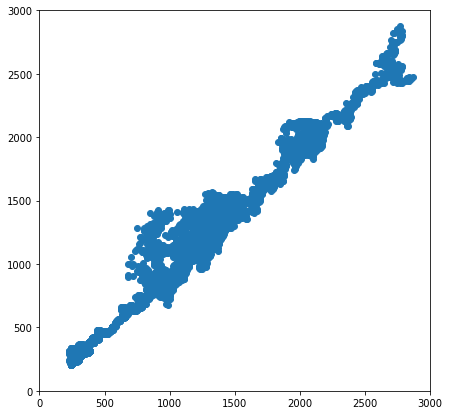

In [6]:
print(spx_shift_100.head(), '\n', spx_shift_100.tail())
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(df.loc[100:, 'close'],
          spx_shift_100.loc[100:, 'close'])
ax.set_xlim(0, 3000)
ax.set_ylim(0, 3000)
plt.show()

In [7]:
#
# the statsmodels plot_acf is based upon the numpy correlate
# function, so we can generate the actual values for 
# illustration and so we can label some later plots
#
# the standard presentation of an acf plot has the value at 
# lag 0 == 1; the correlate function returns unscaled
# values so we get the first value for scaling to 1
#
# the values to be tested in the function must have
# the mean of the un-shifted series subtracted from 
# both series
#
corr0 = np.correlate(df.close[0: ] - 
                     df.close.mean(), 
                     df.close[0: ] - 
                     df.close.mean(), 
                     mode = 'valid')
corrs = [np.correlate(df.close[:(df.close.shape[0] - i)] - 
                      df.close.mean(), 
                      df.close[i: ] - 
                      df.close.mean(), 
                      mode = 'valid')          
         for i in range(max_lag)] / corr0

In [8]:
#
# utility function to plot out a range of 
# plots depicting self-correlation
#
def plot_lag_grid(series, corrs, 
                  axis_min, axis_max, 
                  num_plots, total_lag,
                  n_rows, n_cols):
    lag_step = int(total_lag / num_plots)
    fig = plt.figure(figsize = (18, 16))
    for i in range(num_plots):
        corr = corrs[lag_step * i]
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.scatter(series, series.shift(lag_step * i))
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.set_title('lag = ' + str(lag_step * i))
        ax.text(axis_min + 0.05 * (axis_max - axis_min),
                axis_max - 0.05 * (axis_max - axis_min),
                'correlation = ' + str(round(corr[0], 3)))
    fig.tight_layout()
    plt.show()

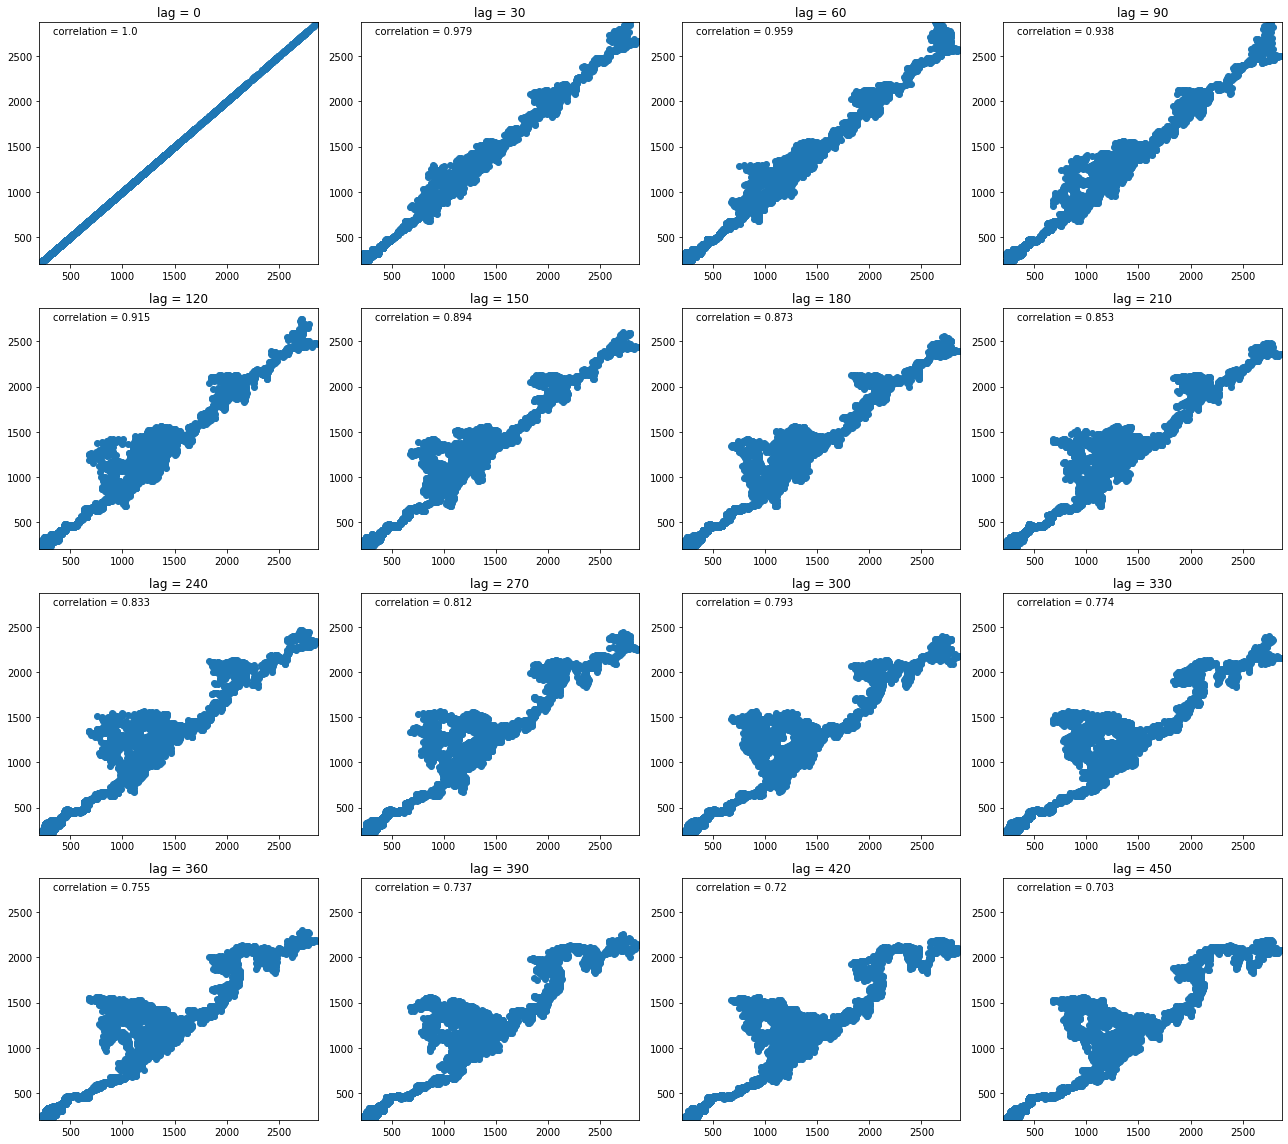

In [9]:
#
# create a grid to see how well the data at increasing 
# lags correlates to the original data
# 
# 'perfect' correlation will appear as a diagonal line
# the farther from the line, the poorer the correlation
#
plot_lag_grid(df.close, corrs,
              df.close.min(), df.close.max(),
              num_plots = 16,
              total_lag = 480,
              n_rows = 4, n_cols = 4)

In [10]:
#
# statsmodels AR function builds an autoregression model
# using all the defaults, it will determine the max lag
# and provide all the model coefficients
#
model = AR(df.close)
model_fit = model.fit()
#
# model fit now contains all the model information
# 
max_lag = model_fit.k_ar
#
# note that by using defaults, the maximum lag is 
# computed as round(12*(nobs/100.)**(1/4.))
# see https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit
#
print('Max Lag: ' + str(max_lag))
print('Coefficients: \n' + str(model_fit.params))
#
# how far into the future we want to predict
#
max_forecast = 365
#
# generate predictions from the model
#
pred_close = pd.DataFrame({'pred_close': 
                           model_fit.predict(start = max_lag,
                                             end = df.shape[0] + 
                                             max_forecast - 1)})
#
# attach the dates for visualization
#
pred_close['date'] = df.loc[pred_close.index, 'date'].reindex()
pred_close.loc[(max(df.index) + 1):, 'date'] = \
    pd.to_datetime([max(df.date) + 
                    pd.Timedelta(days = i)
                    for i in range(1, max_forecast + 1)])

Max Lag: 36
Coefficients: 
const        0.114237
L1.close     0.944153
L2.close     0.008452
L3.close     0.046900
L4.close    -0.014887
L5.close    -0.024734
L6.close     0.025849
L7.close    -0.004821
L8.close     0.009209
L9.close    -0.010451
L10.close    0.033449
L11.close   -0.029657
L12.close    0.052843
L13.close   -0.031489
L14.close   -0.023010
L15.close   -0.018195
L16.close    0.060165
L17.close    0.004425
L18.close   -0.057269
L19.close    0.025184
L20.close    0.008416
L21.close   -0.020273
L22.close    0.024271
L23.close   -0.010330
L24.close    0.004574
L25.close   -0.016035
L26.close    0.005954
L27.close    0.032375
L28.close   -0.037643
L29.close    0.024265
L30.close   -0.006099
L31.close   -0.018106
L32.close    0.005761
L33.close   -0.002750
L34.close   -0.037882
L35.close    0.046765
L36.close    0.000887
dtype: float64


C:\Users\bbate\Miniconda3\envs\keras-gpu\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


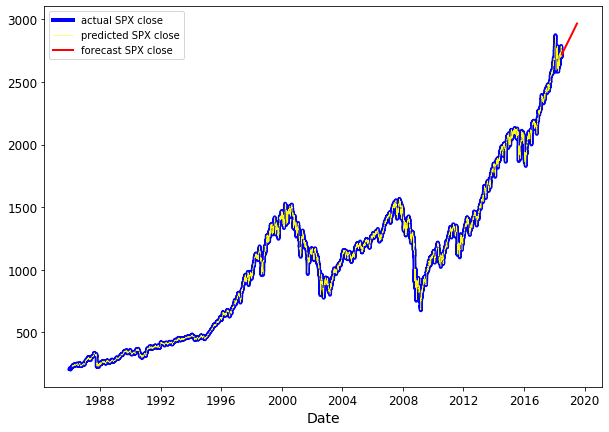

In [11]:
#
# visualize the predictions overlaid on the real data
# as well as the extrapolation to the future
#
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(df.date, 
        df.close, 
        c = "blue", 
        linewidth = 4,
        label = 'actual SPX close')
ax.plot(pred_close.loc[0 : len(df.close), 'date'], 
        pred_close.loc[0 : len(df.close), 'pred_close'], 
        c = "yellow", 
        linewidth = 0.5,
        label = 'predicted SPX close')
ax.plot(pred_close.loc[len(df.close):, 'date'], 
        pred_close.loc[len(df.close):, 'pred_close'], 
        c = "red", 
        linewidth = 2,
        label = 'forecast SPX close')
ax.set_xlabel('Date', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
ax.legend()
plt.show()

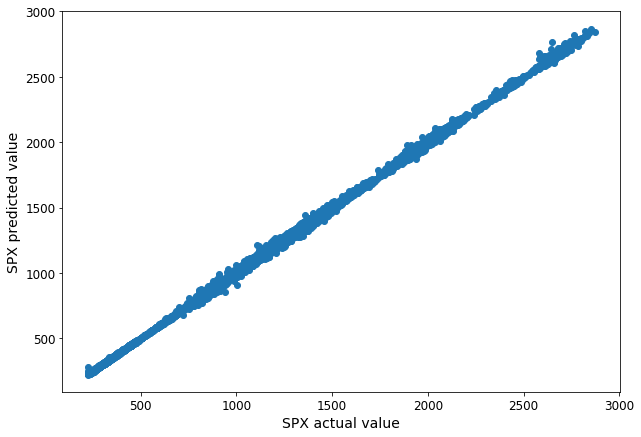

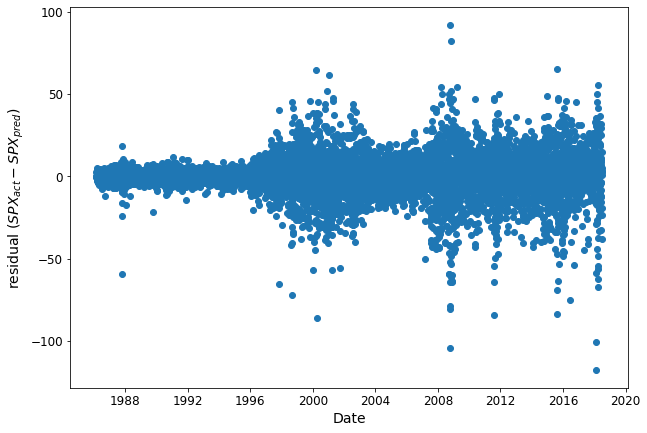

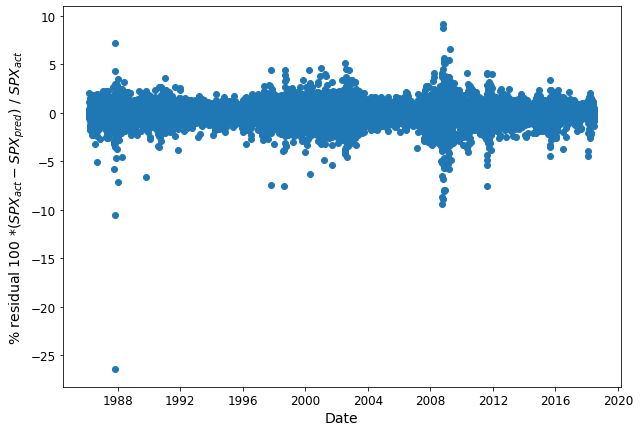

In [12]:
#
# compare predicted vs. actual 
#
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(df.loc[max_lag:(df.shape[0] - 1), 'close'], 
                  pred_close.loc[max_lag:(df.shape[0] - 1), 'pred_close'])
ax.tick_params(axis = 'both', labelsize = 12)
ax.set_xlabel('SPX actual value', fontsize = 14)
ax.set_ylabel('SPX predicted value', fontsize = 14)
plt.show()
#
fig, ax = plt.subplots(figsize = (10, 7))
residuals = pd.DataFrame({'date' : (df.loc[max_lag:(df.shape[0] - 1), 'date']),
                          'residual' : df.loc[max_lag:(df.shape[0] - 1), 'close'] -
                          pred_close.loc[max_lag:(df.shape[0] - 1), 'pred_close']})
ax.scatter(residuals.date, residuals.residual)
ax.tick_params(axis = 'both', labelsize = 12)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('residual (' + r'$SPX_{act} - SPX_{pred}$' + 
              ')', fontsize = 14)
plt.show()
#
fig, ax = plt.subplots(figsize = (10, 7))
pct_residuals = pd.DataFrame({'date' : residuals.date,
                              'pct_residual' : 100 * residuals.residual / 
                              df.loc[max_lag:(df.shape[0] - 1), 'close']})
ax.scatter(pct_residuals.date, pct_residuals.pct_residual)
ax.tick_params(axis = 'both', labelsize = 12)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('% residual 100 *(' + 
              r'$SPX_{act} - SPX_{pred}$' + ') / ' + 
              r'$SPX_{act}$', fontsize = 14)
plt.show()